<h1>Base packages</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<h1>Initialise models</h1>

In [2]:
from GPdoemd.case_studies.analytic import mixing
from GPdoemd.model import Model

_, models = mixing.get()

# Only run CSTR experiments
class CSTR_func:
    def __init__ (self,model):
        self.model = model
    def __call__ (self,x,p):
        return self.model([x[0],x[1],0],p)

Ms = []
for m in models:
    d = {
        'name':        m.name,
        'call':        CSTR_func(m),
        'x_bounds':    m.x_bounds[:2],
        'p_bounds':    m.p_bounds,
        'num_outputs': 1
    }
    Ms.append( Model(d) )

<h1>Measurement model</h1>

In [3]:
# Noise standard deviation
mstd = np.array([0.05])
mvar = mstd**2

def measurement (x):
    # True state
    model = mixing.M3()
    state = model([x[0],x[1],0], np.array([0.015]))
    # Measurement noise
    noise = mstd * np.random.randn(len(state))
    # Measurement
    return np.abs(state + noise)

<h1>Initial data</h1>

In [4]:
from mixing_graphics import MixingGraphics

X = np.array([[20., 0.50],
              [20., 0.75]])
Y = np.array([measurement(x) for x in X])

graphics = MixingGraphics(X,Y,mvar)

<h1>Parameter estimation</h1>

In [5]:
from GPdoemd.param_estim import diff_evol

for M in Ms:
    M.param_estim(X, Y, diff_evol)
    print(M.name + ': ' + str(M.pmean))

M1: [0.00597465]
M2: [0.00604721]
M3: [0.01248164]
M4: [0.02429252]
M5: [0.02337938]


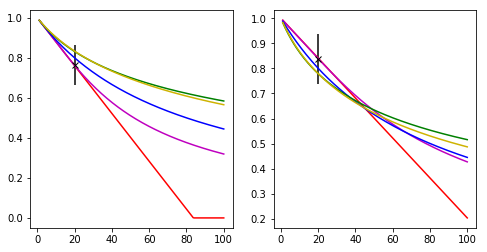

In [6]:
graphics.model_plot(Ms)

<h1>Surrogate models</h1>

In [7]:
from GPdoemd.kernels import RBF, Matern52

def train_models (models):
    for M in models:
        # Training data
        Xsim = np.meshgrid( np.linspace(*M.x_bounds[0], num=20), 
                            np.linspace(*M.x_bounds[1], num=20) )
        Xsim = np.vstack( map(np.ravel, Xsim) ).T
        Xsim = np.vstack( (Xsim, Xsim) )
        Psim = M.pmean * ( 1 + 0.005 * ( 1 - 2 * np.random.rand(len(Xsim), 1) ) )
        Zsim = np.c_[Xsim, Psim]
        Ysim = np.array([M([x[0],x[1]], p) for x, p in zip(Xsim, Psim)])

        # Train GP surrogate
        M.set_training_data(Zsim, Ysim)
        M.gp_surrogate(kern_x=Matern52, kern_p=RBF)
        M.gp_optimize()
    
train_models(Ms)

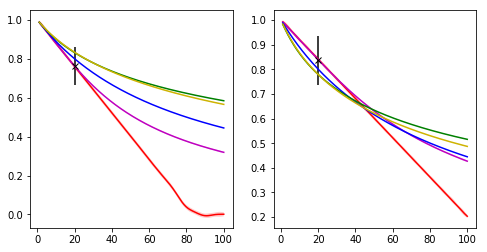

In [8]:
graphics.gp_plot(Ms)

<h1>Marginal predictive distributions</h1>

In [9]:
from GPdoemd.marginals import TaylorFirstOrder

for M in Ms:
    M.meas_noise_var = mvar
    M.marginal_init_and_compute_covar(TaylorFirstOrder, X)

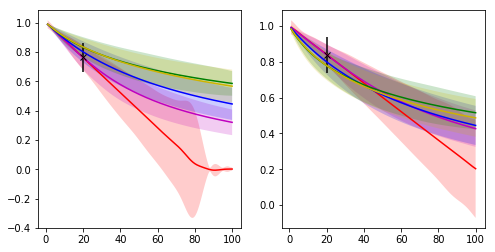

In [10]:
graphics.marginal_plot(Ms)

<h1>Model probabilities</h1>

In [11]:
from scipy.stats import multivariate_normal as mv
from GPdoemd.utils import model_probabilities

pis = model_probabilities(Ms,X,Y)
for M, p in zip(Ms, pis):
    print(M.name + ': ' + '{:.3f}'.format(p))

M1: 0.420
M2: 0.420
M3: 0.136
M4: 0.015
M5: 0.009


<h1>Design the next experiment</h1>

In [12]:
from GPdoemd.utils import marginal_predict
from GPdoemd.design_criteria import HR, BH, BF, AW, JR

# Design criteria
DCs = ['HR', 'BH', 'BF', 'AW', 'JR']

# Test points
xbnd = Ms[0].x_bounds
Xsim = np.meshgrid( np.linspace(*xbnd[0], num=20), 
                    np.linspace(*xbnd[1], num=20) )
Xsim = np.vstack( map(np.ravel, Xsim) ).T
# Predictions
mu,s2 = marginal_predict(Ms,Xsim)

Xnext = []
print('{:4}{:>7}{:>7}'.format('','tau','C0'))
for DC in DCs:
    dc = eval(DC + '(mu,s2,mvar,pis)')
    i  = np.argmax(dc)
    xn = Xsim[i]
    Xnext.append(xn)
    print('{:4}{:7.2f}{:7.2f}'.format(DC+':',*xn))

        tau     C0
HR:   11.42   0.01
BH:   11.42   0.01
BF:   21.84   0.01
AW:   47.89   0.22
JR:   21.84   0.11


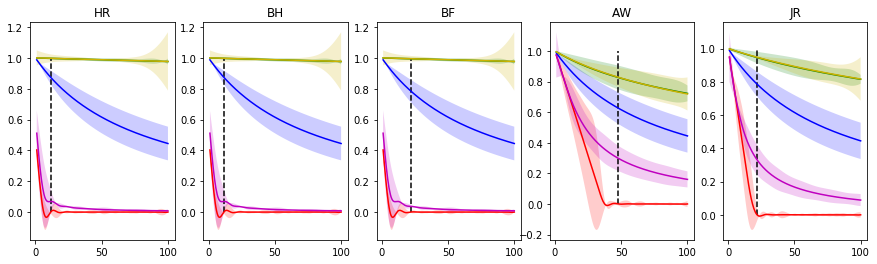

In [13]:
graphics.design_plot(Ms,DCs,Xnext)

<h1>Run experiment suggested by JR design criterion</h1>

In [14]:
xnext = Xnext[-1]
ynext = measurement(xnext)

X = np.vstack(( X, xnext ))
Y = np.vstack(( Y, ynext ))

graphics = MixingGraphics(X, Y, mvar)

<h1>Update surrogate models</h1>

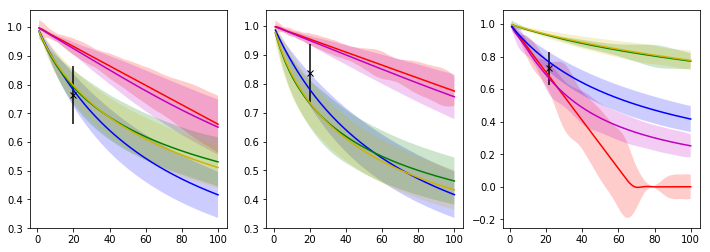

In [15]:
# Parameter estimation
for M in Ms:
    M.param_estim(X, Y, diff_evol)

# Train GP surrogates
train_models(Ms)

# Marginal models
for M in Ms:
    M.marginal_init(TaylorFirstOrder)
    M.marginal_compute_covar(X)
    
graphics.marginal_plot(Ms)

<h1>Updated model probabilities</h1>

In [16]:
# Model probabilities
pis = model_probabilities(Ms,X,Y)
for M, p in zip(Ms, pis):
    print(M.name + ': ' + '{:.3f}'.format(p))

M1: 0.000
M2: 0.000
M3: 1.000
M4: 0.000
M5: 0.000
